In [28]:
# needed lib import
from datetime import datetime
import csv
from StringIO import StringIO

In [29]:
#file paths
trafficPath = "Dodgers.data"
gamesPath = "DodgersEvents"

#creating rdd
traffic = sc.textFile(trafficPath)
games = sc.textFile(gamesPath)

# games.take(10)
traffic.take(1)

[u'4/10/2005 0:00,-1']

In [30]:
# to maniplate the parse Traffic data
def parseTraffic(row):
    DATE_FMT = "%m/%d/%Y %H:%M"
    row = row.split(',')
    row[0] = datetime.strptime(row[0],DATE_FMT)
    row[1] = int(row[1])
    return (row[0],row[1])

In [31]:
#Creating a pair Rdd
trafficParsed = traffic.map(parseTraffic)
trafficParsed.take(1)

[(datetime.datetime(2005, 4, 10, 0, 0), -1)]

In [32]:
# every day how many cars around to the stat.
dailyTrend = trafficParsed.map(lambda x:(x[0].date(),x[1]))\
            .reduceByKey(lambda x,y : x+y)
dailyTrend.take(2)


[(datetime.date(2005, 8, 9), 5958), (datetime.date(2005, 6, 29), 5437)]

In [33]:
dailyTrend.sortBy( lambda x : -x[1]).take(10)

[(datetime.date(2005, 7, 28), 7661),
 (datetime.date(2005, 7, 29), 7499),
 (datetime.date(2005, 8, 12), 7287),
 (datetime.date(2005, 7, 27), 7238),
 (datetime.date(2005, 9, 23), 7175),
 (datetime.date(2005, 7, 26), 7163),
 (datetime.date(2005, 5, 20), 7119),
 (datetime.date(2005, 8, 11), 7110),
 (datetime.date(2005, 9, 8), 7107),
 (datetime.date(2005, 9, 7), 7082)]

In [34]:
#join with Games
def parseGames(row):
    DATE_FMT = "%m/%d/%y"
    row = row.split(",")
    row[0] = datetime.strptime(row[0],DATE_FMT).date()
    return (row[0],row[4])

gamesParsed = games.map(parseGames)
gamesParsed.take(1)

[(datetime.date(2005, 4, 12), u'San Francisco')]

In [35]:
dailyTrendCombined = dailyTrend.leftOuterJoin(gamesParsed)
dailyTrendCombined.take(1)

[(datetime.date(2005, 9, 24), (5848, u'Pittsburgh'))]

In [36]:
# according to date and also team trend without noGameDay
dailyTrendCombined.filter(lambda x : x[1][1]!=None ).sortBy( lambda x : x[1][0]).take(5)

[(datetime.date(2005, 6, 28), (-96, u'San Diego')),
 (datetime.date(2005, 9, 10), (2851, u'San Diego')),
 (datetime.date(2005, 6, 27), (2907, u'San Diego')),
 (datetime.date(2005, 5, 30), (3973, u'Chicago Cubs')),
 (datetime.date(2005, 9, 5), (4023, u'San Francisco'))]

In [37]:
# date, day type, Opponent, How many cars are around to the stat.
def checkGameDay(row):
    if row[1][1] ==None:
        return (row[0],"Regular Day",row[1][1],row[1][0])
    else :
        return (row[0],"--Game day-",row[1][1],row[1][0])
    
dailyTrendByGames = dailyTrendCombined.map(checkGameDay)

In [38]:
dailyTrendByGames.sortBy( lambda x : -x[3]).take(5)

[(datetime.date(2005, 7, 28), '--Game day-', u'Cincinnati', 7661),
 (datetime.date(2005, 7, 29), '--Game day-', u'St. Louis', 7499),
 (datetime.date(2005, 8, 12), '--Game day-', u'NY Mets', 7287),
 (datetime.date(2005, 7, 27), '--Game day-', u'Cincinnati', 7238),
 (datetime.date(2005, 9, 23), '--Game day-', u'Pittsburgh', 7175)]

In [39]:
#average car on game day and regular day
TrendRateOfOpponent = dailyTrendByGames.map(lambda x : (x[2],x[3])).combineByKey( (lambda x : (x,1)),
                                                              (  lambda acc,y : (acc[0]+y ,acc[1]+1 )),
                                                              (  lambda acc1,acc2 : (acc1[0]+acc2[0] , acc1[1]+acc2[1])))\
                    .mapValues( lambda x: (x[0]/x[1]))

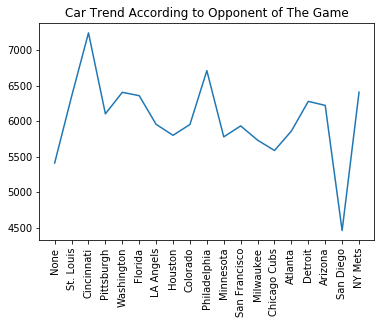

In [40]:
# Graph of the Opponent Trend 
import matplotlib.pyplot as plt

y=list(TrendRateOfOpponent.map(lambda x: int (x[1])).collect())
x=list(TrendRateOfOpponent.map(lambda x: str (x[0]) ).collect())
plt.title("Car Trend According to Opponent of The Game")
plt.plot(x, y)
plt.xticks(x, x, rotation='vertical')
plt.show()